In [2]:
# Let's start by retrieving some Magic card images using the Scryfall API
# https://scryfall.com/docs/api
# We'll be using the Scryfall python library
# https://github.com/NandaScott/Scrython

In [25]:
import requests
from requests.exceptions import TooManyRedirects, ReadTimeout, ConnectionError
import json
import pprint
import time
import shutil
import os
import os.path
import glob
import csv
from PIL import Image
import random
import numpy as np
import errno
import mxnet as mx
import csv
import matplotlib.pyplot as plt

URL='https://api.scryfall.com'
OUTDIR='/Users/agussman/Documents/DeepLens/deeplens-magiccards/data'


In [89]:
r = requests.get('https://api.scryfall.com/cards/search?order=set&q=e:dom')
# TODO: Support Scryfall pagination: https://scryfall.com/docs/api/lists

In [90]:
results = r.json()['data']
for result in results[:1000]:
    #card = result
    #if 'all_parts' in result
    #print(result['image_uris']['png'])
    time.sleep(0.25)
    image_url = result['image_uris']['png']
    filename = "{}_{num:03d}.png".format(result['set'], num=int(result['collector_number']))
    filename = os.path.join(OUTDIR, result['set'], filename)
    print(filename)
    print("{} -> {}".format(image_url, filename))
    
    r = requests.get(image_url, stream=True)
    
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
    
    '''
    if r.status_code == 200:
        with open(os.path.join(OUTDIR, result['set'], filename), 'wb') as out_file:
            shutil.copyfileobj(response.raw(), out_file)
    else:
        print("Nope. {}".format(response.status_code))
    '''
    
    
#pprint.pprint(results[0:2])

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_001.png
https://img.scryfall.com/cards/png/en/dom/1.png?1524789999 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_001.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_002.png
https://img.scryfall.com/cards/png/en/dom/2.png?1525862131 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_002.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_003.png
https://img.scryfall.com/cards/png/en/dom/3.png?1525862133 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_003.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_004.png
https://img.scryfall.com/cards/png/en/dom/4.png?1524790027 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_004.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_005.png
https://img.scryfall.com/cards/png/en/dom/5.png?1528770903 -> /Users

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_040.png
https://img.scryfall.com/cards/png/en/dom/40.png?1524790396 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_040.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_041.png
https://img.scryfall.com/cards/png/en/dom/41.png?1524790406 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_041.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_042.png
https://img.scryfall.com/cards/png/en/dom/42.png?1524790414 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_042.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_043.png
https://img.scryfall.com/cards/png/en/dom/43.png?1524790424 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_043.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_044.png
https://img.scryfall.com/cards/png/en/dom/44.png?1524790433 -> /

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_079.png
https://img.scryfall.com/cards/png/en/dom/79.png?1524790762 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_079.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_080.png
https://img.scryfall.com/cards/png/en/dom/80.png?1524790770 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_080.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_081.png
https://img.scryfall.com/cards/png/en/dom/81.png?1524790780 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_081.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_082.png
https://img.scryfall.com/cards/png/en/dom/82.png?1524790788 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_082.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_083.png
https://img.scryfall.com/cards/png/en/dom/83.png?1524790796 -> /

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_118.png
https://img.scryfall.com/cards/png/en/dom/118.png?1524791156 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_118.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_119.png
https://img.scryfall.com/cards/png/en/dom/119.png?1525864604 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_119.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_120.png
https://img.scryfall.com/cards/png/en/dom/120.png?1524791173 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_120.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_121.png
https://img.scryfall.com/cards/png/en/dom/121.png?1524791187 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_121.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_122.png
https://img.scryfall.com/cards/png/en/dom/122.png?1524791196

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_156.png
https://img.scryfall.com/cards/png/en/dom/156.png?1524791556 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_156.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_157.png
https://img.scryfall.com/cards/png/en/dom/157.png?1524791565 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_157.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_158.png
https://img.scryfall.com/cards/png/en/dom/158.png?1524791574 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_158.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_159.png
https://img.scryfall.com/cards/png/en/dom/159.png?1525862754 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_159.png
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/dom/dom_160.png
https://img.scryfall.com/cards/png/en/dom/160.png?1524791593

In [73]:
# Next let's download some pictures of tables
# TODO: Don't download HTML as a JPG
table_list_url = 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n03201035'
r = requests.get(table_list_url)

file_urls = r.text.splitlines()

In [87]:
for num, table_url in enumerate(file_urls[100:]):
    print(num, table_url)
    time.sleep(0.25)
    filename = "{num:003d}_{original}".format(num=num, original=os.path.basename(table_url))
    filename = os.path.join(OUTDIR, 'tables', filename)
    print(filename)
    print("{} -> {}".format(table_url, filename))
    
    try:
        r = requests.get(table_url, stream=True, timeout=1)
        if r.status_code == 200:
            with open(filename, 'wb') as fd:
                for chunk in r.iter_content(chunk_size=128):
                    fd.write(chunk)
        else:
            print("SKIP: Problem downloading: {}".format(r.status_code))
    except TooManyRedirects:
        print("SKIP: TooManyRedirects")
    except ReadTimeout:
        print("SKIP: ReadTimeout")
    except ConnectionError:
        print("SKIP: ConnectionError")
    


0 http://farm2.static.flickr.com/1395/1474970283_e5a687c70c.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/000_1474970283_e5a687c70c.jpg
http://farm2.static.flickr.com/1395/1474970283_e5a687c70c.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/000_1474970283_e5a687c70c.jpg
1 http://peoplesfurniture.net/images_products/6228_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/001_6228_small.jpg
http://peoplesfurniture.net/images_products/6228_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/001_6228_small.jpg
SKIP: ReadTimeout
2 http://farm1.static.flickr.com/109/277350299_351613348e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/002_277350299_351613348e.jpg
http://farm1.static.flickr.com/109/277350299_351613348e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/002_277350299_351613348e.jpg
3 http://www.gowfb.com/images/imagecache/462-Bo

25 http://farm2.static.flickr.com/1106/1093235054_e664bec93e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/025_1093235054_e664bec93e.jpg
http://farm2.static.flickr.com/1106/1093235054_e664bec93e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/025_1093235054_e664bec93e.jpg
26 http://z.about.com/d/collectibles/1/5/5/_/wilmes10.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/026_wilmes10.jpg
http://z.about.com/d/collectibles/1/5/5/_/wilmes10.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/026_wilmes10.jpg
SKIP: ConnectionError
27 http://peoplesfurniture.net/images_products/4450_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/027_4450_small.jpg
http://peoplesfurniture.net/images_products/4450_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/027_4450_small.jpg
SKIP: ReadTimeout
28 http://bp1.blogger.com/_pU3onm4o7kw/RyfXslOSQ1I/AAAAA

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/049_311957682_9375af06b8.jpg
http://static.flickr.com/101/311957682_9375af06b8.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/049_311957682_9375af06b8.jpg
50 http://farm2.static.flickr.com/1202/1107251587_8cf268f60d.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/050_1107251587_8cf268f60d.jpg
http://farm2.static.flickr.com/1202/1107251587_8cf268f60d.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/050_1107251587_8cf268f60d.jpg
51 http://www.shrivenham.com/Images/Dining.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/051_Dining.jpg
http://www.shrivenham.com/Images/Dining.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/051_Dining.jpg
52 http://www.gowfb.ca/images/imagecache/basra.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/052_basra.jpg
http://www.gowfb.ca/images/imagecache

75 http://www.staxchairs.com.au/productimg/Redang_Dining_ChairsMain1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/075_Redang_Dining_ChairsMain1.jpg
http://www.staxchairs.com.au/productimg/Redang_Dining_ChairsMain1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/075_Redang_Dining_ChairsMain1.jpg
SKIP: Problem downloading: 404
76 http://www.peoplesfurniture.net/images_products/5642_big.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/076_5642_big.jpg
http://www.peoplesfurniture.net/images_products/5642_big.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/076_5642_big.jpg
SKIP: ReadTimeout
77 http://www.gowfb.com/images/imagecache/5%20PC%20Round%20Dining%20Table%20Set%20-%20Walnut%20Finish.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/077_5%20PC%20Round%20Dining%20Table%20Set%20-%20Walnut%20Finish.jpg
http://www.gowfb.com/images/imagecache/5%20PC%20Round%20Dining%20T

99 http://farm1.static.flickr.com/67/217786870_d416932c49.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/099_217786870_d416932c49.jpg
http://farm1.static.flickr.com/67/217786870_d416932c49.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/099_217786870_d416932c49.jpg
100 http://www.ambfurniture.com/catalog/image.php?type=P&amp;id=18704
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/100_image.php?type=P&amp;id=18704
http://www.ambfurniture.com/catalog/image.php?type=P&amp;id=18704 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/100_image.php?type=P&amp;id=18704
SKIP: Problem downloading: 404
101 http://farm1.static.flickr.com/76/187452261_fadd6bfdc8.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/101_187452261_fadd6bfdc8.jpg
http://farm1.static.flickr.com/76/187452261_fadd6bfdc8.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/101_187452261_fadd6bfdc8

SKIP: ReadTimeout
124 http://farm1.static.flickr.com/2/1697203_978fa4ae55.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/124_1697203_978fa4ae55.jpg
http://farm1.static.flickr.com/2/1697203_978fa4ae55.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/124_1697203_978fa4ae55.jpg
125 http://farm3.static.flickr.com/2351/2148232225_a6dffa3821.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/125_2148232225_a6dffa3821.jpg
http://farm3.static.flickr.com/2351/2148232225_a6dffa3821.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/125_2148232225_a6dffa3821.jpg
126 http://farm3.static.flickr.com/2345/2103956653_dbcc7ac9e0.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/126_2103956653_dbcc7ac9e0.jpg
http://farm3.static.flickr.com/2345/2103956653_dbcc7ac9e0.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/126_2103956653_dbcc7ac9e0.jpg
127 http://farm1.static.f

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/148_FurnitureAmericaHome1.jpg
http://www.furnitureamerica.com/images/pictures/FurnitureAmericaHome1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/148_FurnitureAmericaHome1.jpg
SKIP: ConnectionError
149 http://farm4.static.flickr.com/3241/2761951934_38586a60cb.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/149_2761951934_38586a60cb.jpg
http://farm4.static.flickr.com/3241/2761951934_38586a60cb.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/149_2761951934_38586a60cb.jpg
150 http://69.60.255.163/~htdocs/manimages/828/images/124521DiningRoom1large_L.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/150_124521DiningRoom1large_L.jpg
http://69.60.255.163/~htdocs/manimages/828/images/124521DiningRoom1large_L.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/150_124521DiningRoom1large_L.jpg
SKIP: ConnectionE

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/173_2049539613_09cc137556.jpg
http://static.flickr.com/2261/2049539613_09cc137556.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/173_2049539613_09cc137556.jpg
174 http://farm1.static.flickr.com/36/79873236_3c52851db1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/174_79873236_3c52851db1.jpg
http://farm1.static.flickr.com/36/79873236_3c52851db1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/174_79873236_3c52851db1.jpg
175 http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/3812_350.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/175_3812_350.jpg
http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/3812_350.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/175_3812_350.jpg
SKIP: Problem downloading: 404
176 http://farm3.static.flickr.com/2319/2259994233_654253fb6d.jpg
/Use

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/198_wigeon_hall_dining_s.jpg
http://www.modishdecor.com/images/ash_furniture/Dining%20Room/Traditional/wigeon_hall_dining_s.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/198_wigeon_hall_dining_s.jpg
SKIP: ReadTimeout
199 http://farm1.static.flickr.com/41/125687414_dc41f775c0.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/199_125687414_dc41f775c0.jpg
http://farm1.static.flickr.com/41/125687414_dc41f775c0.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/199_125687414_dc41f775c0.jpg
200 http://www.pioneerhandcraft.ca/pinetrestletable.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/200_pinetrestletable.jpg
http://www.pioneerhandcraft.ca/pinetrestletable.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/200_pinetrestletable.jpg
SKIP: Problem downloading: 404
201 http://www.gowfb.ca/images/imagecache/bon

224 http://farm1.static.flickr.com/185/410163063_bcc73ba004.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/224_410163063_bcc73ba004.jpg
http://farm1.static.flickr.com/185/410163063_bcc73ba004.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/224_410163063_bcc73ba004.jpg
225 http://farm1.static.flickr.com/156/421745830_5f173765cb.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/225_421745830_5f173765cb.jpg
http://farm1.static.flickr.com/156/421745830_5f173765cb.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/225_421745830_5f173765cb.jpg
226 http://farm1.static.flickr.com/57/224786422_9daada132a.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/226_224786422_9daada132a.jpg
http://farm1.static.flickr.com/57/224786422_9daada132a.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/226_224786422_9daada132a.jpg
227 http://www.gowfb.com/images/imagecache/Li

249 http://www.dining-room-sets.org.uk/nitro-dining-set.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/249_nitro-dining-set.jpg
http://www.dining-room-sets.org.uk/nitro-dining-set.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/249_nitro-dining-set.jpg
SKIP: ConnectionError
250 http://farm2.static.flickr.com/1403/1258371616_fe756c5aca.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/250_1258371616_fe756c5aca.jpg
http://farm2.static.flickr.com/1403/1258371616_fe756c5aca.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/250_1258371616_fe756c5aca.jpg
251 http://farm2.static.flickr.com/1413/1034106211_fe85b8a679.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/251_1034106211_fe85b8a679.jpg
http://farm2.static.flickr.com/1413/1034106211_fe85b8a679.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/251_1034106211_fe85b8a679.jpg
252 http://www.gowfb.com/

274 http://farm1.static.flickr.com/75/174663547_b42ecc4a6c.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/274_174663547_b42ecc4a6c.jpg
http://farm1.static.flickr.com/75/174663547_b42ecc4a6c.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/274_174663547_b42ecc4a6c.jpg
275 http://www.beiters.com/images/dining2_sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/275_dining2_sm.jpg
http://www.beiters.com/images/dining2_sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/275_dining2_sm.jpg
SKIP: Problem downloading: 404
276 http://g-ec2.images-amazon.com/images/I/51IgB-Em6rL._classic-furniture_.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/276_51IgB-Em6rL._classic-furniture_.jpg
http://g-ec2.images-amazon.com/images/I/51IgB-Em6rL._classic-furniture_.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/276_51IgB-Em6rL._classic-furniture_.jpg
SKIP: Prob

SKIP: Problem downloading: 404
298 http://farm4.static.flickr.com/3060/2313442764_f7b8ccecb4.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/298_2313442764_f7b8ccecb4.jpg
http://farm4.static.flickr.com/3060/2313442764_f7b8ccecb4.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/298_2313442764_f7b8ccecb4.jpg
299 http://www.retrowow.co.uk/retro_style/homes/g-plan3.gif
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/299_g-plan3.gif
http://www.retrowow.co.uk/retro_style/homes/g-plan3.gif -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/299_g-plan3.gif
300 http://static.flickr.com/2416/2204505970_69fbb3540e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/300_2204505970_69fbb3540e.jpg
http://static.flickr.com/2416/2204505970_69fbb3540e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/300_2204505970_69fbb3540e.jpg
301 http://farm1.static.flickr.com/221/5215977

324 http://peoplesfurniture.net/images_products/5645_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/324_5645_small.jpg
http://peoplesfurniture.net/images_products/5645_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/324_5645_small.jpg
SKIP: ReadTimeout
325 http://www.contemporary-furniture-store.com/images/dining-room.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/325_dining-room.jpg
http://www.contemporary-furniture-store.com/images/dining-room.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/325_dining-room.jpg
SKIP: ReadTimeout
326 http://farm3.static.flickr.com/2160/2257705227_04d81c6279.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/326_2257705227_04d81c6279.jpg
http://farm3.static.flickr.com/2160/2257705227_04d81c6279.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/326_2257705227_04d81c6279.jpg
327 http://farm1.static.fli

348 http://farm4.static.flickr.com/3016/2638098376_3868283fe9.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/348_2638098376_3868283fe9.jpg
http://farm4.static.flickr.com/3016/2638098376_3868283fe9.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/348_2638098376_3868283fe9.jpg
349 http://farm2.static.flickr.com/1121/1096796398_dff384ac6b.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/349_1096796398_dff384ac6b.jpg
http://farm2.static.flickr.com/1121/1096796398_dff384ac6b.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/349_1096796398_dff384ac6b.jpg
350 http://farm1.static.flickr.com/24/103427075_4a51f6ceea.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/350_103427075_4a51f6ceea.jpg
http://farm1.static.flickr.com/24/103427075_4a51f6ceea.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/350_103427075_4a51f6ceea.jpg
351 http://farm3.static.flickr.co

SKIP: Problem downloading: 404
373 http://www.bransonfurniture.com/images/cabins/cabins/dining_room.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/373_dining_room.jpg
http://www.bransonfurniture.com/images/cabins/cabins/dining_room.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/373_dining_room.jpg
374 http://www.redleafads.com/photos/class/thumb190/1215879335ghj.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/374_1215879335ghj.jpg
http://www.redleafads.com/photos/class/thumb190/1215879335ghj.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/374_1215879335ghj.jpg
SKIP: Problem downloading: 404
375 http://farm3.static.flickr.com/2407/1763113781_6200cd4a07.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/375_1763113781_6200cd4a07.jpg
http://farm3.static.flickr.com/2407/1763113781_6200cd4a07.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/375_176

398 http://www.peoplesfurniture.net/scart/public/database/product/images_products/5661_big.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/398_5661_big.jpg
http://www.peoplesfurniture.net/scart/public/database/product/images_products/5661_big.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/398_5661_big.jpg
SKIP: ReadTimeout
399 http://bp0.blogger.com/_Ssud8db3HLY/RnMLyOIP4sI/AAAAAAAAAdo/8ZedSKcz9hQ/s400/bm+09.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/399_bm+09.jpg
http://bp0.blogger.com/_Ssud8db3HLY/RnMLyOIP4sI/AAAAAAAAAdo/8ZedSKcz9hQ/s400/bm+09.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/399_bm+09.jpg
400 http://www.indiamart.com/bcexports/pcat-gifs/products-small/2dining-room-furniture.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/400_2dining-room-furniture.jpg
http://www.indiamart.com/bcexports/pcat-gifs/products-small/2dining-room-furniture.jpg -> /Us

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/422_449648891_7623f3664e.jpg?v=0
http://farm1.static.flickr.com/186/449648891_7623f3664e.jpg?v=0 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/422_449648891_7623f3664e.jpg?v=0
423 http://www.metalworksinc.com/PHOTOS/furniture/diningroom_table.gif
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/423_diningroom_table.gif
http://www.metalworksinc.com/PHOTOS/furniture/diningroom_table.gif -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/423_diningroom_table.gif
424 http://farm2.static.flickr.com/1037/1479589030_12fdd7afa1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/424_1479589030_12fdd7afa1.jpg
http://farm2.static.flickr.com/1037/1479589030_12fdd7afa1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/424_1479589030_12fdd7afa1.jpg
425 http://farm1.static.flickr.com/229/453265818_ee29bd5c91.jpg
/Users/agussman/Doc

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/447_dining-room-furniture.jpg
http://www.indiamart.com/renaissanceexports/pcat-gifs/products-small/dining-room-furniture.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/447_dining-room-furniture.jpg
SKIP: Problem downloading: 404
448 http://www.mattressmack.com/macks_weblog/images/2007/12/27/435135745.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/448_435135745.jpg
http://www.mattressmack.com/macks_weblog/images/2007/12/27/435135745.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/448_435135745.jpg
449 http://www.askwatauga.com/Businesses/wolfCreek/images/newImages/furnTableDiningRoom.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/449_furnTableDiningRoom.jpg
http://www.askwatauga.com/Businesses/wolfCreek/images/newImages/furnTableDiningRoom.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/449_furnT

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/471_304715195_05cef89a00.jpg
http://farm1.static.flickr.com/103/304715195_05cef89a00.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/471_304715195_05cef89a00.jpg
472 http://www.guadalajarafurniture.com/diningrooms/table1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/472_table1.jpg
http://www.guadalajarafurniture.com/diningrooms/table1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/472_table1.jpg
SKIP: ReadTimeout
473 http://members.iinet.com.au/~coakeley/proform/table.gif
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/473_table.gif
http://members.iinet.com.au/~coakeley/proform/table.gif -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/473_table.gif
SKIP: Problem downloading: 404
474 http://www.homelement.com/images/md_1371-36-TABLE.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/4

494 http://www.familyoutfitters.org/fots_files/resized/Table_Front_Back.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/494_Table_Front_Back.jpg
http://www.familyoutfitters.org/fots_files/resized/Table_Front_Back.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/494_Table_Front_Back.jpg
SKIP: ReadTimeout
495 http://peoplesfurniture.net/images_products/6513_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/495_6513_small.jpg
http://peoplesfurniture.net/images_products/6513_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/495_6513_small.jpg
SKIP: ReadTimeout
496 http://farm3.static.flickr.com/2353/2173865355_8521bb27ec.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/496_2173865355_8521bb27ec.jpg
http://farm3.static.flickr.com/2353/2173865355_8521bb27ec.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/496_2173865355_8521bb27ec.jpg
497 htt

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/518_bonaparte-dining-room-rectangular-glass-table.JPG
http://www.gowfb.com/images/prod_alts/thumbs/bonaparte-dining-room-rectangular-glass-table.JPG -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/518_bonaparte-dining-room-rectangular-glass-table.JPG
SKIP: Problem downloading: 404
519 http://farm3.static.flickr.com/2137/2359271050_77a2284c4c.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/519_2359271050_77a2284c4c.jpg
http://farm3.static.flickr.com/2137/2359271050_77a2284c4c.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/519_2359271050_77a2284c4c.jpg
520 http://www.greatpricedfurniture.com/images/website/products/51237450/1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/520_1.jpg
http://www.greatpricedfurniture.com/images/website/products/51237450/1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/520

SKIP: ReadTimeout
543 http://www.pinetum.co.uk/NewPinetumProducts/QUERCUSNewOakDining4_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/543_QUERCUSNewOakDining4_small.jpg
http://www.pinetum.co.uk/NewPinetumProducts/QUERCUSNewOakDining4_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/543_QUERCUSNewOakDining4_small.jpg
SKIP: ConnectionError
544 http://www.villaaquilea.com/images/DiningRoom.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/544_DiningRoom.jpg
http://www.villaaquilea.com/images/DiningRoom.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/544_DiningRoom.jpg
SKIP: Problem downloading: 404
545 http://www.ourvictorianhouse.com/Dining%20Room/Dining%20Room%20Complete/dining%20room%20table.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/545_dining%20room%20table.jpg
http://www.ourvictorianhouse.com/Dining%20Room/Dining%20Room%20Complete/dining%20room%20ta

SKIP: ConnectionError
568 http://farm1.static.flickr.com/174/410162816_b9395d7733.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/568_410162816_b9395d7733.jpg
http://farm1.static.flickr.com/174/410162816_b9395d7733.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/568_410162816_b9395d7733.jpg
569 http://farm1.static.flickr.com/108/275356697_f61bd81d0b.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/569_275356697_f61bd81d0b.jpg
http://farm1.static.flickr.com/108/275356697_f61bd81d0b.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/569_275356697_f61bd81d0b.jpg
570 http://farm3.static.flickr.com/2314/2377810388_15df426376.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/570_2377810388_15df426376.jpg
http://farm3.static.flickr.com/2314/2377810388_15df426376.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/570_2377810388_15df426376.jpg
571 http://farm

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/592_dr.jpg
http://www.dominiqueshouse.com/images/dr.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/592_dr.jpg
SKIP: Problem downloading: 404
593 http://64.79.205.169/images/C100331-100332-Set.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/593_C100331-100332-Set.jpg
http://64.79.205.169/images/C100331-100332-Set.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/593_C100331-100332-Set.jpg
SKIP: ConnectionError
594 http://farm4.static.flickr.com/3121/2630777783_bfc736ab2e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/594_2630777783_bfc736ab2e.jpg
http://farm4.static.flickr.com/3121/2630777783_bfc736ab2e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/594_2630777783_bfc736ab2e.jpg
595 http://farm1.static.flickr.com/105/295319768_3463dfd65b.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/da

618 http://static.flickr.com/2286/2059919849_d60cc492f3.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/618_2059919849_d60cc492f3.jpg
http://static.flickr.com/2286/2059919849_d60cc492f3.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/618_2059919849_d60cc492f3.jpg
619 http://www.camposfurniture.com/images/dnrms/dining_2a.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/619_dining_2a.jpg
http://www.camposfurniture.com/images/dnrms/dining_2a.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/619_dining_2a.jpg
SKIP: Problem downloading: 404
620 http://farm4.static.flickr.com/3262/2351835900_0dafc2dd3e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/620_2351835900_0dafc2dd3e.jpg
http://farm4.static.flickr.com/3262/2351835900_0dafc2dd3e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/620_2351835900_0dafc2dd3e.jpg
621 http://farm3.static.flickr.com/202

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/643_295335251_007ad273df.jpg
http://farm1.static.flickr.com/117/295335251_007ad273df.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/643_295335251_007ad273df.jpg
644 http://antiquepurveyor.com/Antique_Dining_Room_216_0049_tn.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/644_Antique_Dining_Room_216_0049_tn.jpg
http://antiquepurveyor.com/Antique_Dining_Room_216_0049_tn.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/644_Antique_Dining_Room_216_0049_tn.jpg
645 http://www.furniturestoreblog.com/images/Millennum%20Dining%20Table%20by%20Ashley%20Furniture.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/645_Millennum%20Dining%20Table%20by%20Ashley%20Furniture.jpg
http://www.furniturestoreblog.com/images/Millennum%20Dining%20Table%20by%20Ashley%20Furniture.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/

668 http://farm1.static.flickr.com/48/126938758_f4df0568a1.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/668_126938758_f4df0568a1.jpg
http://farm1.static.flickr.com/48/126938758_f4df0568a1.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/668_126938758_f4df0568a1.jpg
669 http://farm1.static.flickr.com/1/126167442_59703789a7.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/669_126167442_59703789a7.jpg
http://farm1.static.flickr.com/1/126167442_59703789a7.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/669_126167442_59703789a7.jpg
670 http://farm4.static.flickr.com/3260/2343712658_8385d9f730.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/670_2343712658_8385d9f730.jpg
http://farm4.static.flickr.com/3260/2343712658_8385d9f730.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/670_2343712658_8385d9f730.jpg
671 http://farm2.static.flickr.com/1010/763

SKIP: Problem downloading: 404
693 http://img.photobucket.com/albums/v484/huisman98/DSC03923.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/693_DSC03923.jpg
http://img.photobucket.com/albums/v484/huisman98/DSC03923.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/693_DSC03923.jpg
694 http://www.comfortinstylefurniture.com/diningroom/new_collection/2078dt_2078dc_sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/694_2078dt_2078dc_sm.jpg
http://www.comfortinstylefurniture.com/diningroom/new_collection/2078dt_2078dc_sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/694_2078dt_2078dc_sm.jpg
SKIP: ConnectionError
695 http://www.the-lift.com/images/Tomahawk%20House/livingroom2sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/695_livingroom2sm.jpg
http://www.the-lift.com/images/Tomahawk%20House/livingroom2sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/da

718 http://farm3.static.flickr.com/2344/2273005164_dd2e6136be.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/718_2273005164_dd2e6136be.jpg
http://farm3.static.flickr.com/2344/2273005164_dd2e6136be.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/718_2273005164_dd2e6136be.jpg
719 http://www.dinette.com/content/store/products/37/2/32.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/719_32.jpg
http://www.dinette.com/content/store/products/37/2/32.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/719_32.jpg
SKIP: Problem downloading: 404
720 http://farm4.static.flickr.com/3156/2674343119_3d1359f778.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/720_2674343119_3d1359f778.jpg
http://farm4.static.flickr.com/3156/2674343119_3d1359f778.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/720_2674343119_3d1359f778.jpg
721 http://bp2.blogger.com/_N2MVgW9Vxwc/

743 http://farm4.static.flickr.com/3212/2449518156_7a4b54e332.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/743_2449518156_7a4b54e332.jpg
http://farm4.static.flickr.com/3212/2449518156_7a4b54e332.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/743_2449518156_7a4b54e332.jpg
744 http://www.domesticsale.com/mainclass/photos/thumb190/1193786006jim.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/744_1193786006jim.jpg
http://www.domesticsale.com/mainclass/photos/thumb190/1193786006jim.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/744_1193786006jim.jpg
SKIP: Problem downloading: 404
745 http://www.losangelesfurniture.com/images/fd_bonaparte_418_dining_room_leg_table_2_lg.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/745_fd_bonaparte_418_dining_room_leg_table_2_lg.jpg
http://www.losangelesfurniture.com/images/fd_bonaparte_418_dining_room_leg_table_2_lg.jpg -> /Users/ag

SKIP: ReadTimeout
768 http://farm1.static.flickr.com/227/510918881_8d30a6c2a8.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/768_510918881_8d30a6c2a8.jpg
http://farm1.static.flickr.com/227/510918881_8d30a6c2a8.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/768_510918881_8d30a6c2a8.jpg
769 http://www.gowfb.com/catalog/images/FDPictures0705/437-Scandia-dining-room-furniture-pedestal-table.gif
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/769_437-Scandia-dining-room-furniture-pedestal-table.gif
http://www.gowfb.com/catalog/images/FDPictures0705/437-Scandia-dining-room-furniture-pedestal-table.gif -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/769_437-Scandia-dining-room-furniture-pedestal-table.gif
SKIP: Problem downloading: 404
770 http://farm2.static.flickr.com/1313/1051035685_a509e8e98f.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/770_1051035685_a509e8e98f.jpg
http:/

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/793_diningroom_tables_p1_12.jpg
http://www.bhgfurniture.com/images/diningroom_tables_p1_12.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/793_diningroom_tables_p1_12.jpg
SKIP: ConnectionError
794 http://www.arealfindantiques.com/pictures4.07/RetroDiningRoom.JPG
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/794_RetroDiningRoom.JPG
http://www.arealfindantiques.com/pictures4.07/RetroDiningRoom.JPG -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/794_RetroDiningRoom.JPG
795 http://farm3.static.flickr.com/2216/2238316788_004dce6890.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/795_2238316788_004dce6890.jpg
http://farm3.static.flickr.com/2216/2238316788_004dce6890.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/795_2238316788_004dce6890.jpg
796 http://farm3.static.flickr.com/2389/2179493176_aed7578e2e.jpg
/U

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/818_%7b0CA4256B-0DBE-4AFF-8F99-5AA4A06E5BDC%7d.jpg
http://www.feldmanfurniture.com/pmidimages/%7b0CA4256B-0DBE-4AFF-8F99-5AA4A06E5BDC%7d.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/818_%7b0CA4256B-0DBE-4AFF-8F99-5AA4A06E5BDC%7d.jpg
SKIP: Problem downloading: 404
819 http://farm3.static.flickr.com/2363/2005080708_438562b377.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/819_2005080708_438562b377.jpg
http://farm3.static.flickr.com/2363/2005080708_438562b377.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/819_2005080708_438562b377.jpg
820 http://farm3.static.flickr.com/2090/2048243130_00a4d7aebb.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/820_2048243130_00a4d7aebb.jpg
http://farm3.static.flickr.com/2090/2048243130_00a4d7aebb.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/820_2048243130_00a4d

SKIP: ConnectionError
843 http://www.furnitureontheweb.com/images/Furniture/hm649.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/843_hm649.jpg
http://www.furnitureontheweb.com/images/Furniture/hm649.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/843_hm649.jpg
SKIP: ConnectionError
844 http://farm4.static.flickr.com/3281/2474591681_3e5cbb8417.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/844_2474591681_3e5cbb8417.jpg
http://farm4.static.flickr.com/3281/2474591681_3e5cbb8417.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/844_2474591681_3e5cbb8417.jpg
845 http://farm4.static.flickr.com/3123/2360376551_2c3f36779d.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/845_2360376551_2c3f36779d.jpg
http://farm4.static.flickr.com/3123/2360376551_2c3f36779d.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/845_2360376551_2c3f36779d.jpg
846 http://farm2.

869 http://farm4.static.flickr.com/3036/2610618077_99fc632588.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/869_2610618077_99fc632588.jpg
http://farm4.static.flickr.com/3036/2610618077_99fc632588.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/869_2610618077_99fc632588.jpg
870 http://furniturefromhome.com/images/store/estates_dining_room_2/760x600/image.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/870_image.jpg
http://furniturefromhome.com/images/store/estates_dining_room_2/760x600/image.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/870_image.jpg
871 http://farm3.static.flickr.com/2352/2443807152_471d42cf07.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/871_2443807152_471d42cf07.jpg
http://farm3.static.flickr.com/2352/2443807152_471d42cf07.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/871_2443807152_471d42cf07.jpg
872 http://farm3.

895 http://farm1.static.flickr.com/89/237910540_fb0b37861a.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/895_237910540_fb0b37861a.jpg
http://farm1.static.flickr.com/89/237910540_fb0b37861a.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/895_237910540_fb0b37861a.jpg
896 http://farm1.static.flickr.com/115/314416483_83a84b933c.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/896_314416483_83a84b933c.jpg
http://farm1.static.flickr.com/115/314416483_83a84b933c.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/896_314416483_83a84b933c.jpg
897 http://farm2.static.flickr.com/1001/641600765_5f00454956.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/897_641600765_5f00454956.jpg
http://farm2.static.flickr.com/1001/641600765_5f00454956.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/897_641600765_5f00454956.jpg
898 http://www.eandsgott.com/images/dining_

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/920_1045070771_39b5439845.jpg
http://farm2.static.flickr.com/1042/1045070771_39b5439845.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/920_1045070771_39b5439845.jpg
921 http://img.photobucket.com/albums/v484/huisman98/DSC03922.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/921_DSC03922.jpg
http://img.photobucket.com/albums/v484/huisman98/DSC03922.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/921_DSC03922.jpg
922 http://www.silveradohomedesign.com/Portals/767/diningroom.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/922_diningroom.jpg
http://www.silveradohomedesign.com/Portals/767/diningroom.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/922_diningroom.jpg
SKIP: ConnectionError
923 http://www.familyestatesintuscany.com/wp-content/uploads/2006/03/diningroom.jpg
/Users/agussman/Documents/DeepLen

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/945_cafe-25set-600.jpg
http://www.ssb7.net/users/45089/cafe-25set-600.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/945_cafe-25set-600.jpg
SKIP: ConnectionError
946 http://www.thefurniture.com/store/Images/Pulaski/Costa%20Dorada/687240-60-61-300.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/946_687240-60-61-300.jpg
http://www.thefurniture.com/store/Images/Pulaski/Costa%20Dorada/687240-60-61-300.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/946_687240-60-61-300.jpg
947 http://www.peoplesfurniture.net/images_products/5629_big.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/947_5629_big.jpg
http://www.peoplesfurniture.net/images_products/5629_big.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/947_5629_big.jpg
SKIP: ReadTimeout
948 http://www.francecruises.com/BOATS/Prosperite/Dining.jpg
/Users/

969 http://www.crosskeysantiques.com/images/Thumbnail%20List/Dining_Room_photo_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/969_Dining_Room_photo_small.jpg
http://www.crosskeysantiques.com/images/Thumbnail%20List/Dining_Room_photo_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/969_Dining_Room_photo_small.jpg
970 http://www.kaylormtncabins.com/cabin_rentals/heavenly_hideaway/dining-room-sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/970_dining-room-sm.jpg
http://www.kaylormtncabins.com/cabin_rentals/heavenly_hideaway/dining-room-sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/970_dining-room-sm.jpg
SKIP: Problem downloading: 404
971 http://www.thailandtradenet.com/photos/catalog/dining-room/executive-dining-room.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/971_executive-dining-room.jpg
http://www.thailandtradenet.com/photos/catalog/dining-roo

993 http://kat.prawl.net/wp-content/uploads/2007/07/table.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/993_table.jpg
http://kat.prawl.net/wp-content/uploads/2007/07/table.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/993_table.jpg
SKIP: ReadTimeout
994 http://www.chrissharpcabinets.co.uk/content/diningroomcut2pic.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/994_diningroomcut2pic.jpg
http://www.chrissharpcabinets.co.uk/content/diningroomcut2pic.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/994_diningroomcut2pic.jpg
995 http://image.bizrate.com/resize?sq=160&uid=652903795&mid=34879
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/995_resize?sq=160&uid=652903795&mid=34879
http://image.bizrate.com/resize?sq=160&uid=652903795&mid=34879 -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/995_resize?sq=160&uid=652903795&mid=34879
996 http://www.hometo

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1017_5200_350.jpg
http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/5200_350.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1017_5200_350.jpg
SKIP: Problem downloading: 404
1018 http://www.losangelesfurniture.com/images/uni_avanti_dining_room_1_sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1018_uni_avanti_dining_room_1_sm.jpg
http://www.losangelesfurniture.com/images/uni_avanti_dining_room_1_sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1018_uni_avanti_dining_room_1_sm.jpg
SKIP: Problem downloading: 404
1019 http://www.tietcustomcabinets.com/img/gallery/table2-sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1019_table2-sm.jpg
http://www.tietcustomcabinets.com/img/gallery/table2-sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1019_table2-sm.jpg
SKIP: Problem download

SKIP: Problem downloading: 410
1041 http://www.designinwoodinc.com/images/brandt_diningtable_20.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1041_brandt_diningtable_20.jpg
http://www.designinwoodinc.com/images/brandt_diningtable_20.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1041_brandt_diningtable_20.jpg
1042 http://a248.e.akamai.net/f/248/38434/6h/www.alsto.com/images/en_US/local/products/248x/dining-table-330977.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1042_dining-table-330977.jpg
http://a248.e.akamai.net/f/248/38434/6h/www.alsto.com/images/en_US/local/products/248x/dining-table-330977.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1042_dining-table-330977.jpg
SKIP: Problem downloading: 403
1043 http://farm1.static.flickr.com/254/451486093_57a8e31d37.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1043_451486093_57a8e31d37.jpg
http://farm1.static.fl

1065 http://www.thomasville.com/ProductImages/IrvingPark/DiningRoom/41721_730_350.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1065_41721_730_350.jpg
http://www.thomasville.com/ProductImages/IrvingPark/DiningRoom/41721_730_350.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1065_41721_730_350.jpg
SKIP: Problem downloading: 404
1066 http://www.nwfinewoodworking.com/david_gray/tietn.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1066_tietn.jpg
http://www.nwfinewoodworking.com/david_gray/tietn.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1066_tietn.jpg
SKIP: Problem downloading: 404
1067 http://furniturefromhome.com/images/store/100538-100539/760x600/image.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1067_image.jpg
http://furniturefromhome.com/images/store/100538-100539/760x600/image.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/106

SKIP: Problem downloading: 404
1089 http://www.gowfb.com/images/prod_alts/thumbs/418-Bonaparte-dining-room-pedestal-table-upholstered-chairs.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1089_418-Bonaparte-dining-room-pedestal-table-upholstered-chairs.jpg
http://www.gowfb.com/images/prod_alts/thumbs/418-Bonaparte-dining-room-pedestal-table-upholstered-chairs.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1089_418-Bonaparte-dining-room-pedestal-table-upholstered-chairs.jpg
SKIP: Problem downloading: 404
1090 http://farm4.static.flickr.com/3179/2537469335_b1a3618e34.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1090_2537469335_b1a3618e34.jpg
http://farm4.static.flickr.com/3179/2537469335_b1a3618e34.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1090_2537469335_b1a3618e34.jpg
1091 http://www.furnishingsguide.com/images/Menu/Dining.bmp
/Users/agussman/Documents/DeepLens/deeplens-magiccar

1112 http://pinetummanufacturing.com/NewProducts05Images/MilaneseDiningRoom500.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1112_MilaneseDiningRoom500.jpg
http://pinetummanufacturing.com/NewProducts05Images/MilaneseDiningRoom500.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1112_MilaneseDiningRoom500.jpg
SKIP: ConnectionError
1113 http://www.heplerdesigns.com/images/shirleyjones4.GIF
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1113_shirleyjones4.GIF
http://www.heplerdesigns.com/images/shirleyjones4.GIF -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1113_shirleyjones4.GIF
1114 http://farm3.static.flickr.com/2392/1491017039_ce49638bde.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1114_1491017039_ce49638bde.jpg
http://farm3.static.flickr.com/2392/1491017039_ce49638bde.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1114_1491017039_ce49638bd

SKIP: Problem downloading: 404
1136 http://www.furnitureontheweb.com/images/Furniture/stsk4872tl.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1136_stsk4872tl.jpg
http://www.furnitureontheweb.com/images/Furniture/stsk4872tl.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1136_stsk4872tl.jpg
SKIP: ConnectionError
1137 http://common.csnstores.com/common/products/KLF/KLF1259_l.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1137_KLF1259_l.jpg
http://common.csnstores.com/common/products/KLF/KLF1259_l.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1137_KLF1259_l.jpg
SKIP: Problem downloading: 404
1138 http://www.eco-furniture.com/im/1143/newport-rounddiningtable.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1138_newport-rounddiningtable.jpg
http://www.eco-furniture.com/im/1143/newport-rounddiningtable.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data

SKIP: Problem downloading: 403
1160 http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/3819_350.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1160_3819_350.jpg
http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/3819_350.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1160_3819_350.jpg
SKIP: Problem downloading: 404
1161 http://www.wdass.net/GrlinaBox/graphics/colorphotos/12_1_2004/diningroom.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1161_diningroom.jpg
http://www.wdass.net/GrlinaBox/graphics/colorphotos/12_1_2004/diningroom.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1161_diningroom.jpg
1162 http://www.feldmanfurniture.com/pthumbs/%7b87A4BAFD-F93F-4B05-BAA9-701DA135E80D%7d.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1162_%7b87A4BAFD-F93F-4B05-BAA9-701DA135E80D%7d.jpg
http://www.feldmanfurniture.com/pthumbs/%7b87A4BAFD-F93

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1183_508238854_7cf3e4bf1a.jpg
http://farm1.static.flickr.com/222/508238854_7cf3e4bf1a.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1183_508238854_7cf3e4bf1a.jpg
1184 http://www.feldmanfurniture.com/pthumbs/%7b577A4BB9-9FDC-4DB0-BD24-1E2D73EFF24D%7d.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1184_%7b577A4BB9-9FDC-4DB0-BD24-1E2D73EFF24D%7d.jpg
http://www.feldmanfurniture.com/pthumbs/%7b577A4BB9-9FDC-4DB0-BD24-1E2D73EFF24D%7d.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1184_%7b577A4BB9-9FDC-4DB0-BD24-1E2D73EFF24D%7d.jpg
SKIP: Problem downloading: 404
1185 http://www.dukewood.com/ProductImages/rw2small/imperial-8seater.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1185_imperial-8seater.jpg
http://www.dukewood.com/ProductImages/rw2small/imperial-8seater.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/

1206 http://peoplesfurniture.net/images_products/4446_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1206_4446_small.jpg
http://peoplesfurniture.net/images_products/4446_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1206_4446_small.jpg
SKIP: ReadTimeout
1207 http://static.flickr.com/2021/2198283837_ef8f97b222.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1207_2198283837_ef8f97b222.jpg
http://static.flickr.com/2021/2198283837_ef8f97b222.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1207_2198283837_ef8f97b222.jpg
1208 http://images.lunafurniture.com/DAYD621-35-01-01A.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1208_DAYD621-35-01-01A.jpg
http://images.lunafurniture.com/DAYD621-35-01-01A.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1208_DAYD621-35-01-01A.jpg
1209 http://www.feldmanfurniture.com/pthumbs/%7b024ACF04-B18A-

SKIP: ReadTimeout
1231 http://www.comcore21.com/prodimages-cdls/gf-A1110-xx-CG.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1231_gf-A1110-xx-CG.jpg
http://www.comcore21.com/prodimages-cdls/gf-A1110-xx-CG.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1231_gf-A1110-xx-CG.jpg
SKIP: Problem downloading: 404
1232 http://www.thefurniture.com/store/Images/Pulaski/Victorias%20Manor/661230_261_262_300_301.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1232_661230_261_262_300_301.jpg
http://www.thefurniture.com/store/Images/Pulaski/Victorias%20Manor/661230_261_262_300_301.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1232_661230_261_262_300_301.jpg
1233 http://farm1.static.flickr.com/51/378391502_3eccdf9c05.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1233_378391502_3eccdf9c05.jpg
http://farm1.static.flickr.com/51/378391502_3eccdf9c05.jpg -> /Users/agussman/Document

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1254_diningroom_furniture_matrix.jpg
http://www.casadelsolfurniture.com/images/diningroom/diningroom_furniture_matrix.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1254_diningroom_furniture_matrix.jpg
SKIP: ConnectionError
1255 http://www.bedsandmoreonline.com/images/diningroom2418sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1255_diningroom2418sm.jpg
http://www.bedsandmoreonline.com/images/diningroom2418sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1255_diningroom2418sm.jpg
SKIP: ConnectionError
1256 http://www.greatchandelier.com/GREATCHANDELIERS/images-NEWPS/DININGLG/D493A.JPG
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1256_D493A.JPG
http://www.greatchandelier.com/GREATCHANDELIERS/images-NEWPS/DININGLG/D493A.JPG -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1256_D493A.JPG
1257 http://

SKIP: Problem downloading: 403
1277 http://farm2.static.flickr.com/1331/1440110395_29cb8e7914.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1277_1440110395_29cb8e7914.jpg
http://farm2.static.flickr.com/1331/1440110395_29cb8e7914.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1277_1440110395_29cb8e7914.jpg
1278 http://farm1.static.flickr.com/253/521888579_3298bc1cc2.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1278_521888579_3298bc1cc2.jpg
http://farm1.static.flickr.com/253/521888579_3298bc1cc2.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1278_521888579_3298bc1cc2.jpg
1279 http://www.issm-iseb.org/b2b/pics/Dining_Room_Set.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1279_Dining_Room_Set.jpg
http://www.issm-iseb.org/b2b/pics/Dining_Room_Set.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1279_Dining_Room_Set.jpg
SKIP: ReadTimeout
1

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1301_2272782679_5cac516cb7.jpg
http://farm3.static.flickr.com/2111/2272782679_5cac516cb7.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1301_2272782679_5cac516cb7.jpg
1302 http://www.gowfb.ca/images/imagecache/Nuage-Table-with-Mali-Tan-C.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1302_Nuage-Table-with-Mali-Tan-C.jpg
http://www.gowfb.ca/images/imagecache/Nuage-Table-with-Mali-Tan-C.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1302_Nuage-Table-with-Mali-Tan-C.jpg
SKIP: Problem downloading: 404
1303 http://www.thomasville.com/ProductImages/PalaisJardin/Additions/39321_752_350.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1303_39321_752_350.jpg
http://www.thomasville.com/ProductImages/PalaisJardin/Additions/39321_752_350.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1303_39321_752_350.jpg


SKIP: ReadTimeout
1326 http://farm1.static.flickr.com/18/70184789_48499dfd51.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1326_70184789_48499dfd51.jpg
http://farm1.static.flickr.com/18/70184789_48499dfd51.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1326_70184789_48499dfd51.jpg
1327 http://www.cupboardlove.com/pics/dining/table/farm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1327_farm.jpg
http://www.cupboardlove.com/pics/dining/table/farm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1327_farm.jpg
1328 http://www.dpdoors.com/gifs/dining-room7.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1328_dining-room7.jpg
http://www.dpdoors.com/gifs/dining-room7.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1328_dining-room7.jpg
SKIP: Problem downloading: 404
1329 http://www.adirondackfurniture.com/images/1080sm.jpg
/Users/agussman/Docum

SKIP: ConnectionError
1350 http://www.villaparkhouse.com/images/dining-rm-shad.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1350_dining-rm-shad.jpg
http://www.villaparkhouse.com/images/dining-rm-shad.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1350_dining-rm-shad.jpg
SKIP: ConnectionError
1351 http://www.designat639.com/Photos/mid-century-dining-room.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1351_mid-century-dining-room.jpg
http://www.designat639.com/Photos/mid-century-dining-room.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1351_mid-century-dining-room.jpg
SKIP: ReadTimeout
1352 http://farm4.static.flickr.com/3129/2420077448_9643290489.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1352_2420077448_9643290489.jpg
http://farm4.static.flickr.com/3129/2420077448_9643290489.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1352_24

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1375_ovaltrestle.jpg
http://www.vermontwoods.com/LFC/ovaltrestle.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1375_ovaltrestle.jpg
SKIP: Problem downloading: 404
1376 http://static.flickr.com/1321/1442374371_cdb79eb388.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1376_1442374371_cdb79eb388.jpg
http://static.flickr.com/1321/1442374371_cdb79eb388.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1376_1442374371_cdb79eb388.jpg
1377 http://farm4.static.flickr.com/3176/2625723411_41b0e5d322.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1377_2625723411_41b0e5d322.jpg
http://farm4.static.flickr.com/3176/2625723411_41b0e5d322.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1377_2625723411_41b0e5d322.jpg
1378 http://farm1.static.flickr.com/105/289749820_cabc85d037.jpg
/Users/agussman/Documents/DeepLen

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1398_stsm900t.jpg
http://www.furnitureontheweb.com/images/Furniture/stsm900t.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1398_stsm900t.jpg
SKIP: ConnectionError
1399 http://farm4.static.flickr.com/3105/2560030706_f340f5ec1d.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1399_2560030706_f340f5ec1d.jpg
http://farm4.static.flickr.com/3105/2560030706_f340f5ec1d.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1399_2560030706_f340f5ec1d.jpg
1400 http://www.furnituretrader.com/images/categories/4.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1400_4.jpg
http://www.furnituretrader.com/images/categories/4.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1400_4.jpg
SKIP: Problem downloading: 403
1401 http://www.thomasville.com/ProductImages/ColorCafe/DiningRoom0904/4842_350.jpg
/Users/agussman/Documents

SKIP: Problem downloading: 404
1422 https://www.ambwashington.um.dk/NR/rdonlyres/8168962F-5CCC-4DF6-87AC-820B356932B7/0/diningroom2007.JPG
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1422_diningroom2007.JPG
https://www.ambwashington.um.dk/NR/rdonlyres/8168962F-5CCC-4DF6-87AC-820B356932B7/0/diningroom2007.JPG -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1422_diningroom2007.JPG
SKIP: ConnectionError
1423 http://www.peoplesfurniture.net/images_products/5660_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1423_5660_small.jpg
http://www.peoplesfurniture.net/images_products/5660_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1423_5660_small.jpg
SKIP: ReadTimeout
1424 http://www.modishdecor.com/images/ash_furniture/Dining%20Room/Traditional/monarch_valley_dining_s.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1424_monarch_valley_dining_s.jpg
http://www.modishd

SKIP: ReadTimeout
1446 http://www.bedsandmoreonline.com/images/diningroom2401sm.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1446_diningroom2401sm.jpg
http://www.bedsandmoreonline.com/images/diningroom2401sm.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1446_diningroom2401sm.jpg
SKIP: ConnectionError
1447 http://www.drodd.com/images2/Apr1601.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1447_Apr1601.jpg
http://www.drodd.com/images2/Apr1601.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1447_Apr1601.jpg
1448 http://furniturefromhome.com/images/store/407-03_1/760x600/image.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1448_image.jpg
http://furniturefromhome.com/images/store/407-03_1/760x600/image.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1448_image.jpg
1449 http://farm4.static.flickr.com/3173/2551970774_7d9edcbd62.jpg
/Users/ag

1471 http://www.gowfb.com/images/imagecache/Rivington.JPG
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1471_Rivington.JPG
http://www.gowfb.com/images/imagecache/Rivington.JPG -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1471_Rivington.JPG
SKIP: Problem downloading: 404
1472 http://us.i1.yimg.com/us.yimg.com/i/us/sch/cn/v/v1/w310/455188_400_300.jpeg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1472_455188_400_300.jpeg
http://us.i1.yimg.com/us.yimg.com/i/us/sch/cn/v/v1/w310/455188_400_300.jpeg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1472_455188_400_300.jpeg
1473 http://www.caberfeidh.net/images/dining-room-oct06-500.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1473_dining-room-oct06-500.jpg
http://www.caberfeidh.net/images/dining-room-oct06-500.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1473_dining-room-oct06-500.jpg
1474 http://www.w

1496 http://www.decodesign.in/dining/dd-diningtable-22.gif
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1496_dd-diningtable-22.gif
http://www.decodesign.in/dining/dd-diningtable-22.gif -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1496_dd-diningtable-22.gif
SKIP: Problem downloading: 404
1497 http://peoplesfurniture.net/images_products/4454_small.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1497_4454_small.jpg
http://peoplesfurniture.net/images_products/4454_small.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1497_4454_small.jpg
SKIP: ReadTimeout
1498 http://www.spanishpartners.com/home-furnishing-spain/dining-room-furniture.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1498_dining-room-furniture.jpg
http://www.spanishpartners.com/home-furnishing-spain/dining-room-furniture.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1498_dining-room

1519 http://www.furniture-fair.net/prodimages/NBROY5960.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1519_NBROY5960.jpg
http://www.furniture-fair.net/prodimages/NBROY5960.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1519_NBROY5960.jpg
SKIP: Problem downloading: 404
1520 http://farm4.static.flickr.com/3065/2443371560_a0ea794684.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1520_2443371560_a0ea794684.jpg
http://farm4.static.flickr.com/3065/2443371560_a0ea794684.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1520_2443371560_a0ea794684.jpg
1521 http://www.eco-furniture.com/im/678/twenty-manordiningtable.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1521_twenty-manordiningtable.jpg
http://www.eco-furniture.com/im/678/twenty-manordiningtable.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1521_twenty-manordiningtable.jpg
SKIP: Problem d

/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1541_solid_wood_dining_room_furniture.jpg
http://www.peoplesfurniture.net/scart/public/scart/images_templ/furniture_resources/solid_wood_dining_room_furniture.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1541_solid_wood_dining_room_furniture.jpg
SKIP: ReadTimeout
1542 http://upsidedowncats.com/uploads/27744_thanksgiving_dining_room_table-20071121220305.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1542_27744_thanksgiving_dining_room_table-20071121220305.jpg
http://upsidedowncats.com/uploads/27744_thanksgiving_dining_room_table-20071121220305.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1542_27744_thanksgiving_dining_room_table-20071121220305.jpg
1543 http://www.dumonds.com/images/dining_room_furniture/dining_table_walnut_welch_A.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1543_dining_table_walnut_welch_A.jpg
htt

SKIP: ConnectionError
1564 http://www.gowfb.com/images/imagecache/1258.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1564_1258.jpg
http://www.gowfb.com/images/imagecache/1258.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1564_1258.jpg
SKIP: Problem downloading: 404
1565 http://www.roomsbyus.com/furniture/Casual-dining-Kitchen/casual-dining/01-120581-SETA.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1565_01-120581-SETA.jpg
http://www.roomsbyus.com/furniture/Casual-dining-Kitchen/casual-dining/01-120581-SETA.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1565_01-120581-SETA.jpg
SKIP: Problem downloading: 400
1566 http://oxford.gumtree.com/posting_images/92/21241692__1205153688__1__1-b3e544b333e01920c885c1449e47ee9a.__big__.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1566_21241692__1205153688__1__1-b3e544b333e01920c885c1449e47ee9a.__big__.jpg
http://oxford.g

1587 http://farm1.static.flickr.com/158/395827087_f6c8a5f8ef.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1587_395827087_f6c8a5f8ef.jpg
http://farm1.static.flickr.com/158/395827087_f6c8a5f8ef.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1587_395827087_f6c8a5f8ef.jpg
1588 http://farm2.static.flickr.com/1262/749409935_f9b651512e.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1588_749409935_f9b651512e.jpg
http://farm2.static.flickr.com/1262/749409935_f9b651512e.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1588_749409935_f9b651512e.jpg
1589 http://www.mattressmack.com/macks_weblog/images/2007/12/23/344320700.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1589_344320700.jpg
http://www.mattressmack.com/macks_weblog/images/2007/12/23/344320700.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1589_344320700.jpg
1590 http://www.morfurniture

1612 http://furniturefromhome.com/images/store/17900_st_pierre_leg_table_buffet_splat_chair_gd_copy/280x260/image.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1612_image.jpg
http://furniturefromhome.com/images/store/17900_st_pierre_leg_table_buffet_splat_chair_gd_copy/280x260/image.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1612_image.jpg
1613 http://farm3.static.flickr.com/2353/2219344458_699aeed6fe.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1613_2219344458_699aeed6fe.jpg
http://farm3.static.flickr.com/2353/2219344458_699aeed6fe.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1613_2219344458_699aeed6fe.jpg
1614 http://static.flickr.com/16/20245702_d5a3ee29b6.jpg
/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables/1614_20245702_d5a3ee29b6.jpg
http://static.flickr.com/16/20245702_d5a3ee29b6.jpg -> /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/tables

MissingSchema: Invalid URL '': No schema supplied. Perhaps you meant http://?

In [16]:
def compose_images(foreground_path, background_path):
    # Make sure the foreground path is valid and open the image
    assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
    assert os.path.splitext(foreground_path)[1].lower() == '.png', 'foreground must be a .png file'
    foreground = Image.open(foreground_path)
    foreground_alpha = np.array(foreground.getchannel(3))
    assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
    assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
    assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', 'jpeg'], \
        'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    background = Image.open(background_path)
    background = background.convert('RGBA')
    
    # Rotate the foreground
    angle_degrees = random.randint(0, 359)
    # TODO: try
    # 1/4 of the time keep it close to center
    # 1/4 of the time keep it 90 to 180
    # 1/4 of the time -180 to 180
    # 1/4 of the time anywhere
    foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
    # Scale the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    while (max_xy_position[0] < 0 or max_xy_position[1] < 0):
        print("Scaling down...")
        scale = random.random() * .5 + .5 # Pick something between .5 and 1
        new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
        foreground = foreground.resize(new_size, resample=Image.BICUBIC)
        max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    
    
    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))
    
    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
        
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    alpha_mask = foreground.getchannel(3)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])] 

    return composite, hard_mask, bbox

In [158]:
# Following https://www.immersivelimit.com/tutorials/composing-images-with-python-for-synthetic-datasets
# sometimes this throws a 'composite not defined' error?
foreground_dir = os.path.join(OUTDIR, 'dom')
background_dir = os.path.join(OUTDIR, 'tables')

output_dir = os.path.join(OUTDIR, 'generated')

foregrounds = glob.glob(foreground_dir+"/*.png")
backgrounds = glob.glob(background_dir+"/*.jpg")

# Create a list to keep track of images and mask annotations
csv_lines = []

# Generate 5 new images
n_generated_images = 1500
for i in range(n_generated_images):
    foreground_path = random.choice(foregrounds)
    background_path = random.choice(backgrounds)
    try:
        composite, mask, bbox = compose_images(foreground_path, background_path)
    except OSError:
        next
        
    
    composite_path = os.path.join(output_dir, 'image_{0:04d}.png'.format(i))
    composite.save(composite_path)
    
    #mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
    #mask.save(mask_path)
    
    width, height = composite.size
    csv_lines.append([width, height, bbox, composite_path])



Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling 

In [126]:
# Generating test data
test_dir = os.path.join(OUTDIR, 'test')

# Generate 5 new images
for i in range(10):
    foreground_path = random.choice(foregrounds)
    background_path = random.choice(backgrounds)
    try:
        composite, mask, bbox = compose_images(foreground_path, background_path)
    except OSError:
        next

    composite_path = os.path.join(test_dir, 'image_{0:04d}.png'.format(i))
    composite.save(composite_path)
    
    mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
    mask.save(mask_path)
    
    width, height = composite.size


Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...
Scaling down...


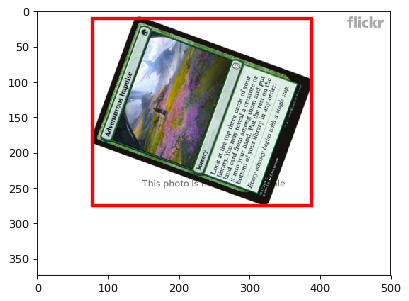

In [75]:
dpi = 80
margin = 0.05 # (5% of the width/height of the figure...)
#xpixels, ypixels = 800, 800

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
figsize = (1 + margin) * height / dpi, (1 + margin) * width / dpi

fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

ax.imshow(composite, interpolation='none')
ymin, xmin, ymax, xmax = bbox
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
ax.add_patch(rect)
plt.show()

In [160]:
# Output the annotations csv
# Using file layout from here: https://mxnet.incubator.apache.org/versions/master/api/python/image/image.html
# id header_width object_width object_id, xmin, ymin, xmax, ymax image_path
annotations_csv_path = os.path.join(OUTDIR, 'train.lst')
with open(annotations_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for idx, csv_line in enumerate(csv_lines):
        width = csv_line[0]
        height = csv_line[1]
        bbox = csv_line[2]
        image_path = csv_line[3]
        outrow = [idx, 4, 5, width, height, idx, bbox[0] / height, bbox[1] / width, bbox[2] / height, bbox[3] / width, image_path]
        writer.writerow(outrow)

In [161]:
batch_size = 32 # Number of examples per batch, some examples are 4, pikachu uses 32
data_shape = 256 # Data shape in (channels, height, width) format. For now, only RGB image with 3 channels is supported.
                 # some example had 224, but pikachu example uses 256
data_iter = mx.image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
                                      path_imglist=OUTDIR+'/train.lst', path_root='/')

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 0.0000000e+00
 1.4666666e-01 2.6800001e-01 8.1333333e-01 7.6800001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0000.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.3300000e+02 1.0000000e+00
 2.7027028e-02 8.6000003e-02 9.0990990e-01 5.2399999e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0001.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 2.0000000e+00
 1.7333333e-01 8.6000003e-02 9.0399998e-01 5.5800003e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0002.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 3.0000000e+00
 2.5333333e-01 4.1999999e-01 9.7600001e-01 9.7200000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0003.png


AG label 
[4.00e+00 5.00e+00 5.00e+02 3.75e+02 9.30e+01 4.80e-02 1.68e-01 8.56e-01
 7.36e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0093.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 9.4000000e+01
 6.1333332e-02 1.0400000e-01 9.6266669e-01 7.8399998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0094.png
AG label 
[4.000000e+00 5.000000e+00 3.740000e+02 5.300000e+01 9.500000e+01
 7.547170e-02 8.235294e-01 7.358491e-01 9.251337e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0095.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 9.6000000e+01
 1.0666667e-02 3.6800000e-01 9.7066665e-01 9.7399998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0096.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3

AG label 
[4.0000000e+00 5.0000000e+00 5.0100000e+02 2.8800000e+02 2.1400000e+02
 6.5972224e-02 2.6946107e-01 9.8263890e-01 7.8842318e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0214.png
AG label 
[4.0000000e+00 5.0000000e+00 3.7500000e+02 5.0000000e+02 2.1500000e+02
 1.7800000e-01 2.5333333e-01 7.3199999e-01 8.7199998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0215.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.740000e+02 2.160000e+02
 8.823530e-02 3.120000e-01 8.903743e-01 8.160000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0216.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.740000e+02 2.170000e+02
 8.823530e-02 3.120000e-01 8.903743e-01 8.160000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0217.png
AG label 
[4.00000

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 3.2100000e+02
 2.5866666e-01 3.6199999e-01 9.8933333e-01 7.5400001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0321.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 3.2200000e+02
 2.5866666e-01 3.6199999e-01 9.8933333e-01 7.5400001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0322.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 3.2300000e+02
 2.5866666e-01 3.6199999e-01 9.8933333e-01 7.5400001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0323.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.740000e+02 3.240000e+02
 8.556150e-02 4.880000e-01 8.235294e-01 9.080000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0324.png
AG label 

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 4.3000000e+02
 2.0266667e-01 9.3999997e-02 8.5333335e-01 5.1599997e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0430.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 4.3100000e+02
 7.9999998e-02 3.3000001e-01 8.7733334e-01 7.6599997e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0431.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 4.3200000e+02
 7.9999998e-02 3.3000001e-01 8.7733334e-01 7.6599997e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0432.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 4.3300000e+02
 2.1333333e-02 3.1600001e-01 9.8666668e-01 8.7800002e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0433.png


AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.740000e+02 5.450000e+02
 4.812834e-02 1.440000e-01 9.251337e-01 9.240000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0545.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7400000e+02 5.4600000e+02
 1.3101605e-01 1.2800001e-01 8.9839572e-01 8.9800000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0546.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.330000e+02 5.470000e+02
 9.909910e-02 2.200000e-01 8.228228e-01 8.480000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0547.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.330000e+02 5.480000e+02
 9.909910e-02 2.200000e-01 8.228228e-01 8.480000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0548.png
AG label 
[4.0000000e+00 5.

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7400000e+02 6.5500000e+02
 3.4759358e-02 2.9400000e-01 7.1122992e-01 9.0799999e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0655.png
AG label 
[4.00e+00 5.00e+00 2.50e+02 2.00e+02 6.56e+02 1.25e-01 1.68e-01 8.10e-01
 7.48e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0656.png
AG label 
[4.00e+00 5.00e+00 5.00e+02 3.75e+02 6.57e+02 9.60e-02 2.20e-02 9.76e-01
 6.16e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0657.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 6.5800000e+02
 8.2666665e-02 2.8600001e-01 9.5733333e-01 8.8999999e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0658.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 6.5900000e+02
 8.266666

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 7.6500000e+02
 4.5333333e-02 2.3000000e-01 9.7600001e-01 8.8400000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0765.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 7.6600000e+02
 2.3199999e-01 1.4200000e-01 9.2266667e-01 5.4000002e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0766.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7400000e+02 7.6700000e+02
 1.6042780e-02 7.1999997e-02 9.3582886e-01 6.9599998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0767.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7400000e+02 7.6800000e+02
 1.6042780e-02 7.1999997e-02 9.3582886e-01 6.9599998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0768.png


AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 8.7300000e+02
 2.6666667e-02 5.0000001e-02 6.1333334e-01 6.6600001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0873.png
AG label 
[4.0000000e+00 5.0000000e+00 3.7400000e+02 5.3000000e+01 8.7400000e+02
 1.8867925e-02 7.2994655e-01 9.4339621e-01 9.1176468e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0874.png
AG label 
[4.0000000e+00 5.0000000e+00 3.7400000e+02 5.3000000e+01 8.7500000e+02
 1.8867925e-02 7.2994655e-01 9.4339621e-01 9.1176468e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0875.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 8.7600000e+02
 2.9333333e-02 1.0000000e-01 9.5200002e-01 7.5599998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0876.png


AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 9.8300000e+02
 2.6666667e-02 1.7200001e-01 7.1466666e-01 8.3800000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0983.png
AG label 
[4.0000000e+00 5.0000000e+00 4.8000000e+02 3.6000000e+02 9.8400000e+02
 1.8055555e-01 9.1666669e-02 8.3888888e-01 6.2708336e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0984.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7400000e+02 9.8500000e+02
 1.3368984e-01 1.3600001e-01 9.4919789e-01 8.6199999e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0985.png
AG label 
[4.000000e+00 5.000000e+00 3.750000e+02 5.000000e+02 9.860000e+02
 2.720000e-01 9.600000e-02 7.940000e-01 7.413333e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0986.png
AG label 

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.0890000e+03
 2.1333333e-02 7.9999998e-02 9.3333334e-01 9.4599998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1089.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.0900000e+03
 2.1333333e-02 7.9999998e-02 9.3333334e-01 9.4599998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1090.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.340000e+02 1.091000e+03
 7.485030e-02 2.600000e-02 8.532934e-01 4.940000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1091.png
AG label 
[4.0000000e+00 5.0000000e+00 3.7500000e+02 5.0000000e+02 1.0920000e+03
 1.5200000e-01 1.5733333e-01 6.7000002e-01 9.6266669e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1092.png
AG label 

AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.750000e+02 1.198000e+03
 2.000000e-01 2.840000e-01 8.613333e-01 7.640000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1198.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.1990000e+03
 1.8666666e-02 3.9999999e-02 7.7866668e-01 6.0799998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1199.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.2000000e+03
 1.8666666e-02 3.9999999e-02 7.7866668e-01 6.0799998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1200.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.2010000e+03
 5.8666665e-02 1.6000001e-02 8.2933331e-01 7.2000003e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1201.png
AG label 

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.3140000e+03
 8.5333332e-02 1.6400000e-01 8.2133335e-01 7.7800000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1314.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 1.3150000e+03
 2.1333333e-02 2.6600000e-01 5.9200001e-01 5.9399998e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1315.png
AG label 
[4.0000000e+00 5.0000000e+00 1.6000000e+02 1.2000000e+02 1.3160000e+03
 3.3333335e-02 8.1249997e-02 9.7500002e-01 8.1250000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1316.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.330000e+02 1.317000e+03
 2.012012e-01 3.460000e-01 8.618619e-01 7.380000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1317.png
AG label 

AG label 
[4.000000e+00 5.000000e+00 2.500000e+02 1.590000e+02 1.439000e+03
 8.176101e-02 2.920000e-01 9.685535e-01 8.000000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1439.png
AG label 
[4.000000e+00 5.000000e+00 5.000000e+02 3.740000e+02 1.440000e+03
 5.882353e-02 5.000000e-02 9.278075e-01 5.480000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1440.png
AG label 
[4.000000e+00 5.000000e+00 2.000000e+02 2.220000e+02 1.441000e+03
 4.954955e-02 1.700000e-01 6.486486e-01 8.650000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1441.png
AG label 
[4.000e+00 5.000e+00 3.750e+02 5.000e+02 1.442e+03 2.100e-01 2.400e-02
 8.300e-01 9.840e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1442.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 0.0000000e+00
 1.4666666e-01 2.6800001e-01 8.1333333e-01 7.6800001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0000.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.3300000e+02 1.0000000e+00
 2.7027028e-02 8.6000003e-02 9.0990990e-01 5.2399999e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0001.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 2.0000000e+00
 1.7333333e-01 8.6000003e-02 9.0399998e-01 5.5800003e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0002.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 3.0000000e+00
 2.5333333e-01 4.1999999e-01 9.7600001e-01 9.7200000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0003.png


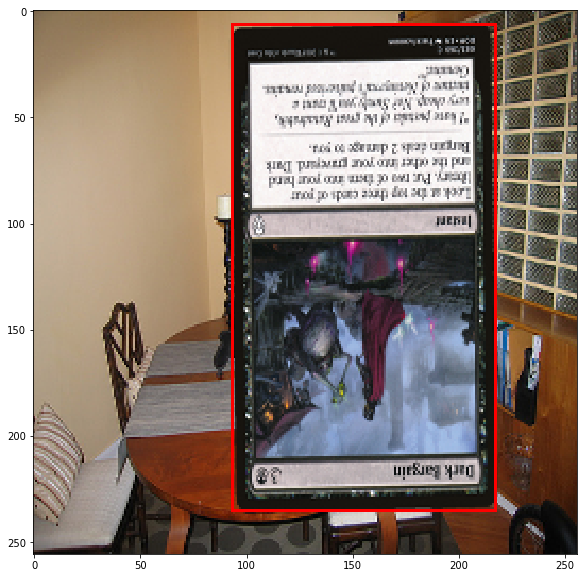

In [162]:
# https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html
data_iter.reset()
batch = data_iter.next()
#print(batch)
#data_shape = 256

i = 9

img = batch.data[0][i].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
#img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)

# Create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(img)

# draw bounding boxes on image
for label in batch.label[0][i].asnumpy():
    if label[0] < 0:
        print("MISSING LABEL????")
        break
    print(label)
    ymin, xmin, ymax, xmax = [int(x * data_shape) for x in label[1:5]]
    #xmin, ymin, xmax, ymax = label[1:5]
    # scale to new size
    #xmin, ymin, xmax, ymax = 58, 179, 150, 279
    #xmin, ymin, xmax, ymax = label[, 179, 150, 279
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    ax.add_patch(rect)

plt.show()

AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.7500000e+02 0.0000000e+00
 1.5466666e-01 3.4000000e-01 9.8133332e-01 9.2400002e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0000.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 4.4100000e+02 1.0000000e+00
 7.0294783e-02 7.4000001e-02 7.7324265e-01 6.9800001e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0001.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.2300000e+02 2.0000000e+00
 2.0743035e-01 2.2400001e-01 9.7523218e-01 5.8800000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0002.png
AG label 
[4.0000000e+00 5.0000000e+00 5.0000000e+02 3.2300000e+02 3.0000000e+00
 2.0743035e-01 2.2400001e-01 9.7523218e-01 5.8800000e-01]
<NDArray 9 @cpu(0)> fname /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_0003.png


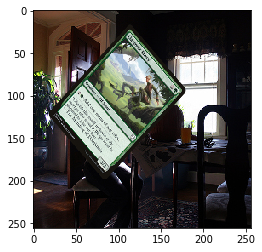

In [80]:
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
#for i in range(4):
#    plt.subplot(1,4,i+1)
#    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.imshow(data[1].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

In [ ]:
# Working forward from https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html

In [101]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>


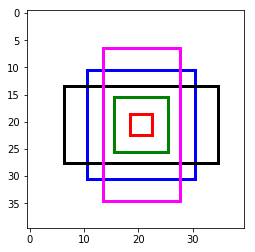

In [102]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [103]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 55, 20, 20)


In [104]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


In [105]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


In [106]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [107]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [108]:
# TODO This needs to be made something actual?
# from the text: Common choices follow the architectures of the state-of-the-art convolution neural 
# networks for image classification. For demonstration purpose, we just stack several down sampling 
# blocks to form the body network.
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


In [110]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (5): Activati

In [111]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [113]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [114]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)


Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 3) box prediction (1, 21776)


In [171]:
class_names = ['magic_card']
num_class = len(class_names)
train_data = data_iter

In [172]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [173]:
from mxnet import gluon
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)


FocalLoss(batch_axis=0, w=None)


In [174]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [175]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

In [176]:
from mxnet import nd
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

# This reports no GPU...
# Looks like I'd need to follow instructions here to get it to work:
# https://mxnet.incubator.apache.org/install/index.html

No GPU enabled, fall back to CPU, sit back and be patient...


In [177]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [178]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [187]:
# DID YOU SET train_data above?
#epochs = 150  # set larger to get better performance
epochs = 50
log_interval = 20
from_scratch = True  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 148
    pretrained = 'ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not osp.exists(pretrained) or not verified(pretrained, sha1):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_params(pretrained, ctx)

In [ ]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

print('{} training images, {} epochs (%f)'.format(n_generated_images, epochs, time.time()-tic))    
# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

In [204]:
# Test
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image
i = 7
image = cv2.imread(os.path.join(test_dir, 'image_{0:04d}.png'.format(i)))
x = preprocess(image)
print('x', x.shape)

x (1, 3, 256, 256)


In [205]:
# if pre-trained model is provided, we can load it
# net.load_params('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.151625    0.151625  ]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ...
  [ 0.01949999  0.01949999  0.9805      0.9805    ]
  [-0.12225395  0.18887302  1.1222539   0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.1222539 ]]]
<NDArray 1x5444x4 @cpu(0)>
class predictions 
[[[ 0.82885396 -1.197525  ]
  [ 0.7456922  -0.749466  ]
  [ 1.0420566  -0.76617575]
  ...
  [ 0.18469065  0.23915952]
  [ 0.00261186 -0.21089809]
  [ 0.58787644  0.01094263]]]
<NDArray 1x5444x2 @cpu(0)>
box delta predictions 
[[-0.05351491  0.15475562  0.20022622 ...  0.16814387  0.6758426
  -1.2429545 ]]
<NDArray 1x21776 @cpu(0)>


In [206]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 0.          0.6011024   0.07368186  0.08187032  0.8566483
    0.8095263 ]
  [-1.          0.58396715  0.08955494  0.13878933  0.90629816
    0.86073077]
  [-1.          0.5136139   0.05430469  0.1060088   0.9262911
    0.8811097 ]
  ...
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]]]
<NDArray 1x5444x6 @cpu(0)>


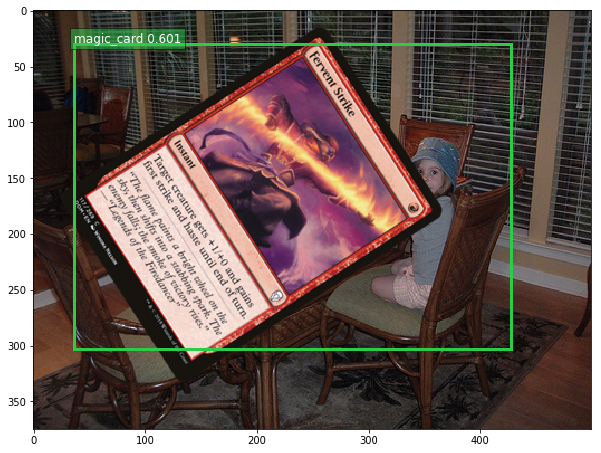

In [207]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

thresh = 0.45
#thresh = 0.55
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=thresh)

In [4]:
import time

query = input("Type the name of the set: ")

time.sleep(0.05)
sets = scrython.sets.Sets()

for i in range(sets.data_length()):
    if sets.set_name(i) == query:
        print("Set code:", sets.set_code(i).upper())
        break
    else:
        continue

Type the name of the set: dom


RuntimeError: Cannot run the event loop while another loop is running